# Albumentations
https://github.com/albumentations-team/albumentations

In [1]:
!pip install albumentations

ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 액세스가 거부되었습니다: 'c:\\users\\it강남-e강의장(강사용)\\appdata\\local\\programs\\python\\python38\\Lib\\site-packages\\cv2\\cv2.cp38-win_amd64.pyd'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\users\it강남-e강의장(강사용)\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [7]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [15]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1* size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img


In [16]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name']. \
                          isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image / 255.
            
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [17]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

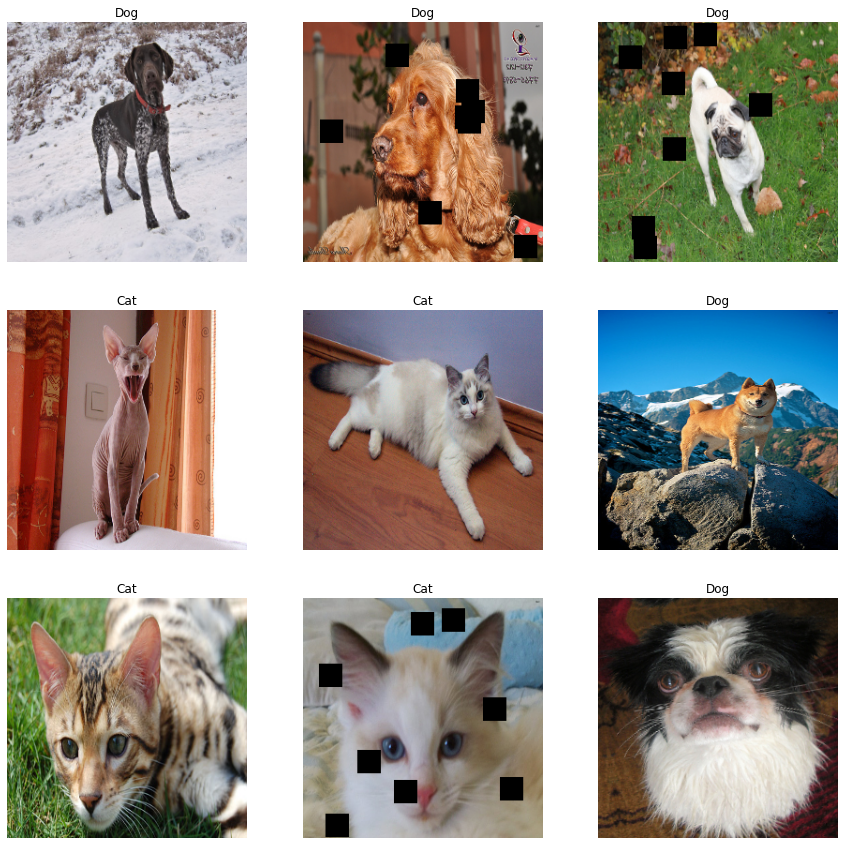

In [20]:
class_names = ['Cat', 'Dog']

for batch in train_generator:
    X, y = batch
    plt.figure(figsize=(15, 15))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(X[i])
        plt.title(class_names[y[i]])
        plt.axis('off')
    break

In [21]:
def get_sequential_model(input_shape):
    model = keras.Sequential(
        [
            # Input
            layers.Input(input_shape),

            # 1st Conv block
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(64, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.5),

            # 2nd Conv block
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.Conv2D(128, 3, strides=1, activation='relu', padding='same'),
            layers.MaxPool2D(),
            layers.BatchNormalization(),
            layers.Dropout(0.3),
        
            # Classfier
            layers.GlobalMaxPool2D(),
            layers.Dense(128, activation='relu'),
            layers.Dense(1, activation='sigmoid')
        ]
    )

    return model

input_shape = (256, 256, 3)
model = get_sequential_model(input_shape)

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics='accuracy'
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 64)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 64)     256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     7

In [26]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[
        early_stopping,
        reduce_on_plateau,
        model_checkpoint
    ],
    verbose=1
)

Epoch 1/10
35/46 [=====================>........] - ETA: 6:08 - loss: 1.1730 - accuracy: 0.6384

KeyboardInterrupt: 

In [23]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=3, verbose=1,
    mode='min', restore_best_weights=False
)

In [24]:
reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.1, patience=10, verbose=1,
    mode='min', min_lr=0.001
)

In [25]:
filepath = '{epoch:02d}-{val_loss:.2f}.hdf5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=False, mode='min'
)